In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.special as spsp
import scipy.stats as spst
from statsmodels.base.model import GenericLikelihoodModel

# Setting

In this problem, we have a simulated dataset that contains two columns: **lambda** and **t**. The values of **lambda** are generated from a gamma distribution with parameters $\gamma=1$ and $\alpha=2$. Using each observation of $\lambda$ along with $c=2$, a corresponding value of $t$ is generated from a Weibull distribution.

In [3]:
Data = pd.read_csv("Data.csv")
Data

,lambda,t
0,0.737717,0.761881
1,0.010485,12.564622
2,0.502081,1.107216
3,0.690761,1.193429
4,0.345083,0.812329
...,...,...
995,0.362410,2.615255
996,0.117958,2.413434
997,0.090229,2.598580
998,0.585508,2.239545


# Part 1 [12 pts]

Use the data to estimate two models. Model 1 is a simple Weibull model estimating the values $\hat c$ and $\hat\lambda$. Model 2 is a Weibull-Gamma model estimating the values of $\hat c$, $\hat\gamma$, and $\hat\alpha$.

* Show the summaries of the two models with appropriately named parameters.

* Generate a plot that overlays the PDFs of Model 1 and Model 2, as well as the histogram of the **t** data values (use `density=True` and `bins=50`), all on one figure. Plot these in the range from 0 to 30, and use a legend to label the two PDFs.

In [4]:
# I'm running everything locally.
# Mimic what's we have from the lecture. Model 1. 
class Weibull_C(GenericLikelihoodModel):
    def loglike(self, params):
        t, _ = self.endog, self.exog
        c, l = np.exp(params)
        likelihood = spst.weibull_min.pdf(t, c = c, scale=l ** (-1/c))
        return np.sum(np.log(likelihood))

In [5]:
Data['t']

0       0.761881
1      12.564622
2       1.107216
3       1.193429
4       0.812329
         ...    
995     2.615255
996     2.413434
997     2.598580
998     2.239545
999     0.879659
Name: t, Length: 1000, dtype: float64

In [6]:
Model = Weibull_C(Data['t']).fit(start_params=-np.random.random(2), method="bfgs")
Model.summary(xname=["log_c", "log_lmbda"])

Optimization terminated successfully.
         Current function value: 1.832451
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Weibull_C Results                               
==============================================================================
Dep. Variable:                      t   Log-Likelihood:                -1832.5
Model:                      Weibull_C   AIC:                             3673.
Method:            Maximum Likelihood   BIC:                             3693.
Date:                Mon, 11 Nov 2024                                         
Time:                        15:09:09                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_c          0.0245      0.022      1.127      0.260      -0.018       0.067
log_lmbda     -0.8663      0.044    -19.822      0.000      -0.952      -0.781
==============================================================================
"""

In [7]:
# Model 2. Formulas from lectures.
class WG_C(GenericLikelihoodModel):
    def loglike(self, params):
        t, _ = self.endog, self.exog        
        c, gamma, alpha = np.exp(params)
        Fwg = (c * gamma * t ** (c) * alpha ** gamma) / (t * (alpha + (t) ** c) ** (gamma + 1) )
        return np.sum(np.log(Fwg))

In [8]:
Model2 = WG_C(Data['t']).fit(start_params=-np.random.random(3), method="bfgs")
Model2.summary(xname=["log_c", "log_gamma", "log_alpha"])

Optimization terminated successfully.
         Current function value: 1.708527
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WG_C Results                                 
==============================================================================
Dep. Variable:                      t   Log-Likelihood:                -1708.5
Model:                           WG_C   AIC:                             3429.
Method:            Maximum Likelihood   BIC:                             3459.
Date:                Mon, 11 Nov 2024                                         
Time:                        15:09:09                                         
No. Observations:                1000                                         
Df Residuals:                     997                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_c          0.7055      0.049     14.450      0.000       0.610       0.801
log_gamma     -0.0979      0.110     -0.893      0.372      -0.313       0.117
log_alpha      0.5980      0.152      3.947      0.000       0.301       0.895
==============================================================================
"""

/var/folders/5w/ypk97qgs7_s3jcbfbhcpmlsw0000gn/T/ipykernel_21276/2648504044.py:9: RuntimeWarning: invalid value encountered in divide
  plt.plot(y, c2*gamma2*y**c2*alpha2**gamma2/(y*(alpha2+y**c2)**(gamma2+1)), label="weibull-gamma")


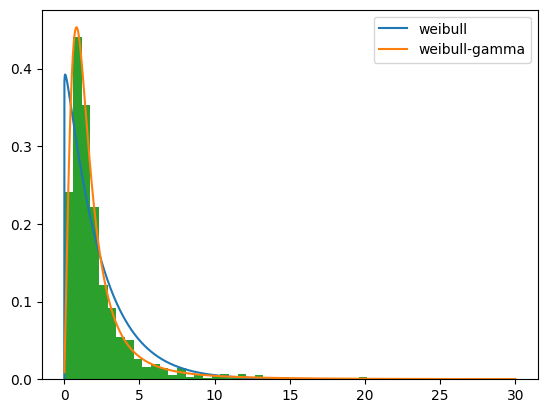

In [13]:
y = np.arange(0,30,.01)

# What's needed to plot for Model 1: 
c1, lmbda1 = np.exp(Model.params)
plt.plot(y, spst.weibull_min.pdf(y, c=c1, scale=lmbda1**(-1/c1)), label="weibull")

# What's needed to plot for Model 2: 
c2, gamma2, alpha2 = np.exp(Model2.params[0:3])
plt.plot(y, c2*gamma2*y**c2*alpha2**gamma2/(y*(alpha2+y**c2)**(gamma2+1)), label="weibull-gamma")


plt.hist(Data["t"], density=True, bins=50)
plt.legend()
plt.show()

# Part 2 [14 pts]

Now let's suppose that our dataset exhibits right censoring, and that we only make time observations up to $T=5$. 

* Create a new column in the dataset **rcensored** that has value equal to **t** if **t** less than 5, and value equal to 5 otherwise.

* Estimate two Weibull-Gamma models using the new **rcensored** values. Model 1 does not account for censoring (same estimation procedure as Model 2 in Part 1); Model 2 correctly accounts for censoring. Show the model summaries.

* Generate a plot that overlays the PDFs of Model 1 and Model 2, as well as the histogram of the **t** data values (use `density=True` and `bins=50`), all on one figure. Plot these in the range from 0 to 30, and use a legend to label the two PDFs.

In [ ]:
Data['rcensored'] = Data['t'].apply(lambda x: x if x < 5 else 5)
print(Data)

       lambda          t  rcensored
0    0.737717   0.761881   0.761881
1    0.010485  12.564622   5.000000
2    0.502081   1.107216   1.107216
3    0.690761   1.193429   1.193429
4    0.345083   0.812329   0.812329
..        ...        ...        ...
995  0.362410   2.615255   2.615255
996  0.117958   2.413434   2.413434
997  0.090229   2.598580   2.598580
998  0.585508   2.239545   2.239545
999  0.050015   0.879659   0.879659

[1000 rows x 3 columns]


In [ ]:
(Data['t'] > 5).sum()

85

In [ ]:
(Data['t'] == 5).sum()

0

In [ ]:
# Model 2. Formulas from lectures.
class WG_C(GenericLikelihoodModel):
    def loglike(self, params):
        t, _ = self.endog, self.exog        
        c, gamma, alpha = np.exp(params)
        fwg = (c * gamma * t ** (c - 1) * alpha ** gamma) / (t * (alpha + (t) ** c) ** (gamma + 1) )
        return np.sum(np.log(fwg))

In [ ]:
Model2 = WG_C(Data['rcensored'].values).fit(start_params=-np.random.random(3), method="bfgs")
Model2.summary(xname=["log_c", "log_gamma", "log_alpha"])

Optimization terminated successfully.
         Current function value: 1.873043
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WG_C Results                                 
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -1873.0
Model:                           WG_C   AIC:                             3758.
Method:            Maximum Likelihood   BIC:                             3788.
Date:                Wed, 09 Oct 2024                                         
Time:                        22:28:45                                         
No. Observations:                1000                                         
Df Residuals:                     997                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_c          0.4071      0.061      6.647      0.000       0.287       0.527
log_gamma      1.9853      0.809      2.454      0.014       0.400       3.571
log_alpha      2.9657      0.836      3.545      0.000       1.326       4.605
==============================================================================
"""

In [ ]:
class WG_C_p2(GenericLikelihoodModel):
    def loglike(self, params):
        t, X = self.endog, self.exog
        censored = np.where(t == 5, 1, 0)
        c, gamma, alpha = np.exp(params[0:3])
        # for non-censored
        fwg = (c * gamma * t ** (c - 1) * alpha ** gamma) / (t * (alpha + (t) ** c) ** (gamma + 1) )
        # for right-censored
        Fwg = 1 - (alpha/(alpha+(t)**c))**gamma
        likelihood = np.where(censored == 0, fwg, Fwg)
        return np.sum(np.log(likelihood))

In [ ]:
Model3 = WG_C_p2(Data['rcensored']).fit(start_params=-np.random.random(3), method="bfgs")
print(Model3.summary(xname=["log_c", "log_gamma", "log_alpha"]))

Optimization terminated successfully.
         Current function value: 1.404591
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
                               WG_C_p2 Results                                
Dep. Variable:              rcensored   Log-Likelihood:                -1404.6
Model:                        WG_C_p2   AIC:                             2821.
Method:            Maximum Likelihood   BIC:                             2851.
Date:                Wed, 09 Oct 2024                                         
Time:                        22:28:55                                         
No. Observations:                1000                                         
Df Residuals:                     997                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

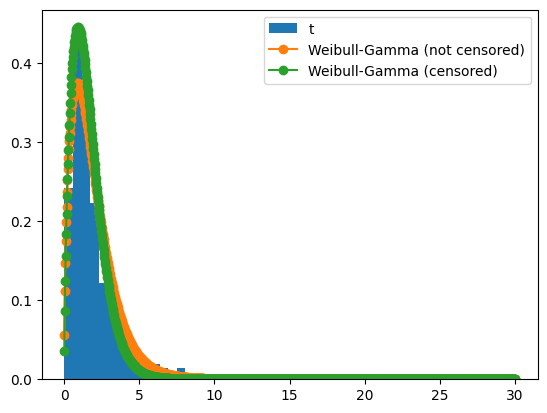

In [ ]:
t = np.linspace(0.01, 30, 1000)

# What's needed to plot for Model 2: 
c2, gamma2, alpha2 = np.exp(Model2.params[0:3])
pdf_WG = (c2 * gamma2 * (t ** (c2)) * (alpha2 ** gamma2)) / (t * (alpha2 + (t) ** c2) ** (gamma2 + 1) )
# or simply plug in formula for Weibull distribution

# What's needed to plot for Model 3: 
c3, gamma3, alpha3 = np.exp(Model3.params[0:3])
pdf_WG3 = (c3 * gamma3 * (t ** (c3)) * (alpha3 ** gamma3)) / (t * (alpha3 + (t) ** c3) ** (gamma3 + 1) )

plt.hist(Data['t'], bins = 50, density = True, label = 't')
plt.plot(t,pdf_WG,marker="o", label = 'Weibull-Gamma (not censored)')
plt.plot(t, pdf_WG3, marker='o', label = 'Weibull-Gamma (censored)')
plt.legend()
plt.show()

# Part 3 [14 pts]

Now let's suppose that our dataset exhibits interval censoring with intervals of length $0.5$. 

* Create a new column in the dataset **icensored** that has value equal to **t** rounded up to the nearest $n$ or $n+0.5$ value, where $n \in \mathbb Z$. For example, 2.31 rounds up to 2.5, and 2.68 rounds up to 3.0.

* Estimate two Weibull-Gamma models using the new **icensored** values. Model 1 does not account for censoring (same estimation procedure as Model 1 in Part 2); Model 2 correctly accounts for censoring. Show the model summaries.

* Generate a plot that overlays the PDFs of Model 1 and Model 2, as well as the histogram of the **t** data values (use `density=True` and `bins=50`), all on one figure. Plot these in the range from 0 to 30, and use a legend to label the two PDFs.

In [ ]:
def rounding(x):
    return np.ceil(x*2)/2
Data['icensored'] = Data['t'].apply(rounding)

In [ ]:
Data

,lambda,t,rcensored,icensored
0,0.737717,0.761881,0.761881,1.0
1,0.010485,12.564622,5.000000,13.0
2,0.502081,1.107216,1.107216,1.5
3,0.690761,1.193429,1.193429,1.5
4,0.345083,0.812329,0.812329,1.0
...,...,...,...,...
995,0.362410,2.615255,2.615255,3.0
996,0.117958,2.413434,2.413434,2.5
997,0.090229,2.598580,2.598580,3.0
998,0.585508,2.239545,2.239545,2.5


In [ ]:
# Model 2. Formulas from lectures.
class WG_C6(GenericLikelihoodModel):
    def loglike(self, params):
        t, _ = self.endog, self.exog        
        c, gamma, alpha = np.exp(params)
        fwg = (c * gamma * t ** (c - 1) * alpha ** gamma) / (t * (alpha + (t) ** c) ** (gamma + 1) )
        return np.sum(np.log(fwg))

In [ ]:
Model6 = WG_C6(Data['icensored'].values).fit(start_params=-np.random.random(3), method="bfgs")
Model6.summary(xname=["log_c", "log_gamma", "log_alpha"])

Optimization terminated successfully.
         Current function value: 2.313726
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                                WG_C6 Results                                 
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -2313.7
Model:                          WG_C6   AIC:                             4639.
Method:            Maximum Likelihood   BIC:                             4669.
Date:                Wed, 09 Oct 2024                                         
Time:                        22:51:11                                         
No. Observations:                1000                                         
Df Residuals:                     997                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_c          1.0697      0.054     19.718      0.000       0.963       1.176
log_gamma     -0.5108      0.102     -5.028      0.000      -0.710      -0.312
log_alpha      0.7431      0.138      5.394      0.000       0.473       1.013
==============================================================================
"""

In [ ]:
class WG_C_p3(GenericLikelihoodModel):
    def loglike(self, params):
        t, _ = self.endog, self.exog
        c, gamma, alpha = np.exp(params[0:3])
        F1 = 1 - (alpha/(alpha+(t - 0.5)**c))**gamma
        F2 = 1 - (alpha/(alpha+(t)**c))**gamma

        interval_here = F2 - F1
        intervalll = np.clip(interval_here, 1e-10, None)
        return np.sum(np.log(intervalll))

In [ ]:
Model5 = WG_C_p3(Data['icensored']).fit(start_params=-np.random.random(3), method="bfgs")
print(Model5.summary(xname=["log_c", "log_gamma", "log_alpha"]))

Optimization terminated successfully.
         Current function value: 2.419111
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
                               WG_C_p3 Results                                
Dep. Variable:              icensored   Log-Likelihood:                -2419.1
Model:                        WG_C_p3   AIC:                             4850.
Method:            Maximum Likelihood   BIC:                             4880.
Date:                Wed, 09 Oct 2024                                         
Time:                        22:58:19                                         
No. Observations:                1000                                         
Df Residuals:                     997                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

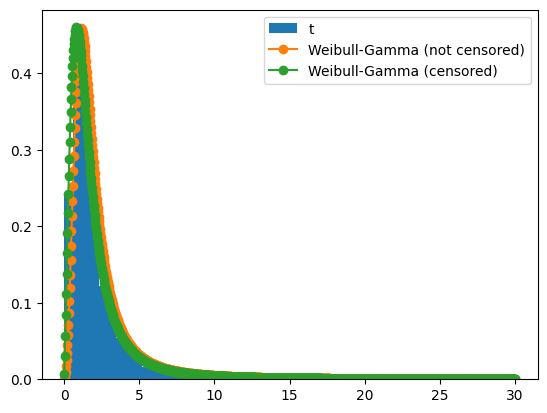

In [ ]:
t = np.linspace(0.01, 30, 1000)

# What's needed to plot for Model 2: 
c2, gamma2, alpha2 = np.exp(Model6.params[0:3])
pdf_WG = (c2 * gamma2 * (t ** (c2)) * (alpha2 ** gamma2)) / (t * (alpha2 + (t) ** c2) ** (gamma2 + 1) )
# or simply plug in formula for Weibull distribution

# What's needed to plot for Model 3: 
c3, gamma3, alpha3 = np.exp(Model5.params[0:3])
pdf_WG3 = (c3 * gamma3 * (t ** (c3)) * (alpha3 ** gamma3)) / (t * (alpha3 + (t) ** c3) ** (gamma3 + 1) )

plt.hist(Data['t'], bins = 50, density = True, label = 't')
plt.plot(t,pdf_WG,marker="o", label = 'Weibull-Gamma (not censored)')
plt.plot(t, pdf_WG3, marker='o', label = 'Weibull-Gamma (censored)')
plt.legend()
plt.show()